In [1]:
import keras
from keras import layers

In [2]:
inputs = layers.Input(shape=(224, 224, 3))
x = layers.ZeroPadding2D(padding=3)(inputs)
x = layers.Conv2D(filters=64, kernel_size=7, strides=2, activation='relu')(x)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)


2025-07-15 16:10:15.292990: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-07-15 16:10:15.293021: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-15 16:10:15.293029: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-07-15 16:10:15.293043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-15 16:10:15.293058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
x = layers.ZeroPadding2D(padding=1)(x)
x = layers.MaxPooling2D(pool_size=3, strides=2)(x)


In [4]:
def residual_block(x, filters, first_stride=1, conv_skip=False):
    skip_conn = x
    # 합성곱과 배치 정규화, 렐루 활성화 함수를 반복합니다
    # 1x1, filters개 필터, 스트라이드는 first_stride에 따라 1 또는 2
    x = layers.Conv2D(filters=filters, kernel_size=1,
                      strides=first_stride)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    # 3x3, filters개 필터
    x = layers.Conv2D(filters=filters, kernel_size=3,
                      padding='same')(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    # 1x1, filters*4개 필터
    x = layers.Conv2D(filters=filters*4, kernel_size=1)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    # conv_skip이 True이면 1x1 합성곱을 사용해 채널 크기를 filters*4로 늘립니다
    if conv_skip == True:
        skip_conn = layers.Conv2D(filters=filters*4, kernel_size=1,
                                  strides=first_stride)(skip_conn)
        skip_conn = layers.BatchNormalization(epsilon=1e-5)(skip_conn)
    x = layers.Add()([skip_conn, x])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def residual_stack(x, blocks, filters):
    for _ in range(blocks):
        x = residual_block(x, filters)
    return x


def build_stack(x):
    for blocks, filters in [(3, 64), (4, 128), (6, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters)
        for _ in range(blocks):
            x = residual_block(x, filters)
    return x

SyntaxError: invalid syntax (2129961568.py, line 9)

In [10]:
def residual_stack(x, blocks, filters, first_stride=2):
    x = residual_block(x, filters, first_stride=first_stride)
    for _ in range(1, blocks):
        x = residual_block(x, filters, first_stride=1)
    return x


def build_stack(x):
    x = residual_stack(x, 3, 64, first_stride=1)

    for blocks, filters in [(4, 128), (6, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters, first_Stride=2)
    return x

In [12]:
def build_stack(x):
    x = residual_stack(x, 3, 64, first_stride=1)
    for blocks, filters in [(4, 128), (6, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters, first_stride=2)
    return x

def residual_stack(x, blocks, filters, first_stride=2):
    x = residual_block(x, filters, first_stride=first_stride, conv_skip=True)

    for _ in range(1, blocks):
        x = residual_block(x, filters, first_stride=1, conv_skip=False)
    return x

In [13]:
x = build_stack(x)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1000, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_11[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_13[0][0] 

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
data_path = "../data/dogs-vs-cats"

In [ ]:
from PIL import Image
import numpy as np
from keras.applications import resnet50


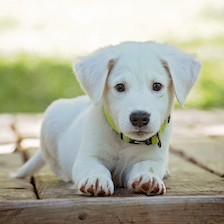

In [65]:
dog_png = Image.open(data_path + '/images/dog.png')
display(dog_png)

resnet_prep_doc = resnet.preprocess_input(np.array(dog_png))

In [49]:
resnet152V2 = keras.applications.ResNet152V2()
resnet152 = keras.applications.ResNet152()
resnet50 = keras.applications.ResNet50()

In [73]:
predictions = resnet152.predict(resnet_prep_doc[np.newaxis, :])

resnet.decode_predictions(predictions)
# print(len(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


[[('n02099601', 'golden_retriever', 0.16981147),
  ('n02099712', 'Labrador_retriever', 0.15997253),
  ('n02104029', 'kuvasz', 0.111874975),
  ('n04409515', 'tennis_ball', 0.061311167),
  ('n02111500', 'Great_Pyrenees', 0.059564173)]]

In [74]:
pred_dogs = resnet.decode_predictions(predictions)[0][:5]
print(pred_dogs)

[('n02099601', 'golden_retriever', 0.16981147), ('n02099712', 'Labrador_retriever', 0.15997253), ('n02104029', 'kuvasz', 0.111874975), ('n04409515', 'tennis_ball', 0.061311167), ('n02111500', 'Great_Pyrenees', 0.059564173)]


FileNotFoundError: [Errno 2] No such file or directory: '../data/dogs-vs-cats/imagenette/n04409515_tennis_ball.jpeg'

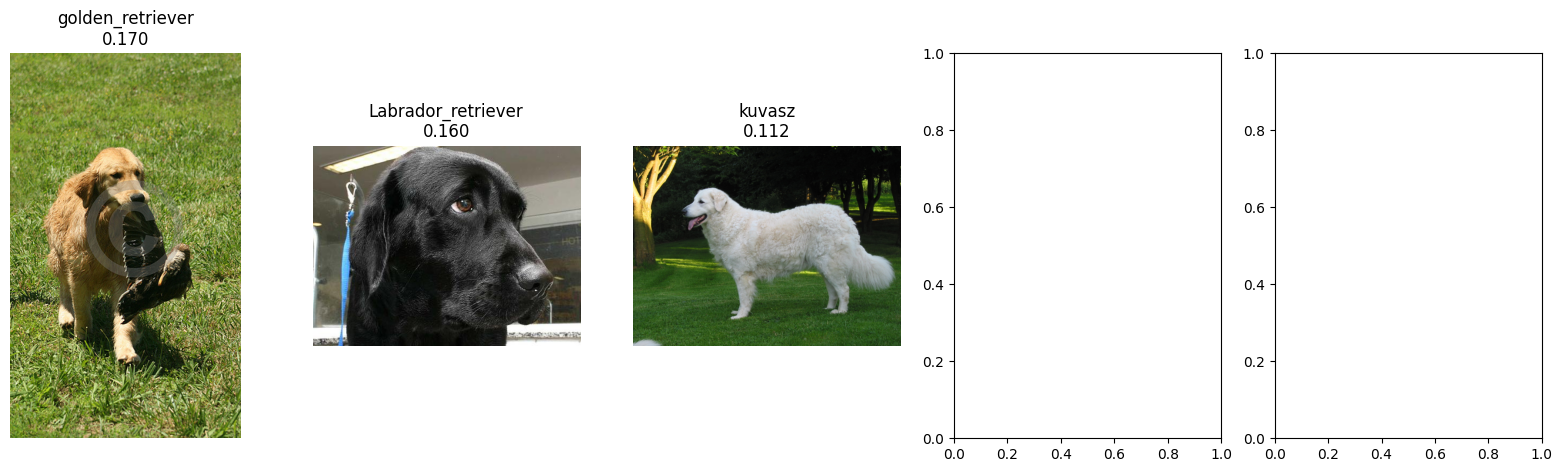

In [75]:
imagenet_dogs = [("n02099712_Labrador_retriever.jpeg", "Labrador_retriever", "0.3853525"), 
  ("n02099601_golden_retriever.jpeg", "golden_retriever", "0.089699596"), 
  ("n02100735_English_setter.jpeg", "English_setter", "0.042124234"),
  ("n02106166_Border_collie.jpeg", "Border_collie", "0.03777436"),
  ("n02101388_Brittany_spaniel.jpeg", "Brittany_spaniel", "0.030700454"), 
]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(pred_dogs), figsize=(20, 5))
for ax, (label, name, score) in zip(axes, pred_dogs):
    cat_png = Image.open(data_path + '/imagenette/' + label + "_" + name + ".jpeg")
    ax.imshow(cat_png)
    ax.axis('off')
    ax.set_title(f"{name}\n{float(score):.3f}", fontsize=12)
plt.tight_layout()
plt.show()

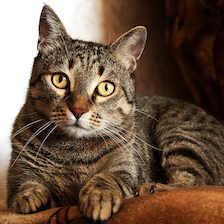

In [76]:
from PIL import Image
import numpy as np

cat_png = Image.open(data_path + '/images/cat.png')
display(cat_png)

In [77]:
resnet_prep_doc = resnet.preprocess_input(np.array(cat_png))

In [78]:
predictions = resnet50.predict(resnet_prep_doc[np.newaxis, :])
resnet.decode_predictions(predictions)

pred_cats = resnet.decode_predictions(predictions)[0][:5]
print(pred_cats)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[('n02123045', 'tabby', 0.8686101), ('n02124075', 'Egyptian_cat', 0.050775014), ('n02123159', 'tiger_cat', 0.04256697), ('n07930864', 'cup', 0.0027631472), ('n03443371', 'goblet', 0.002099163)]


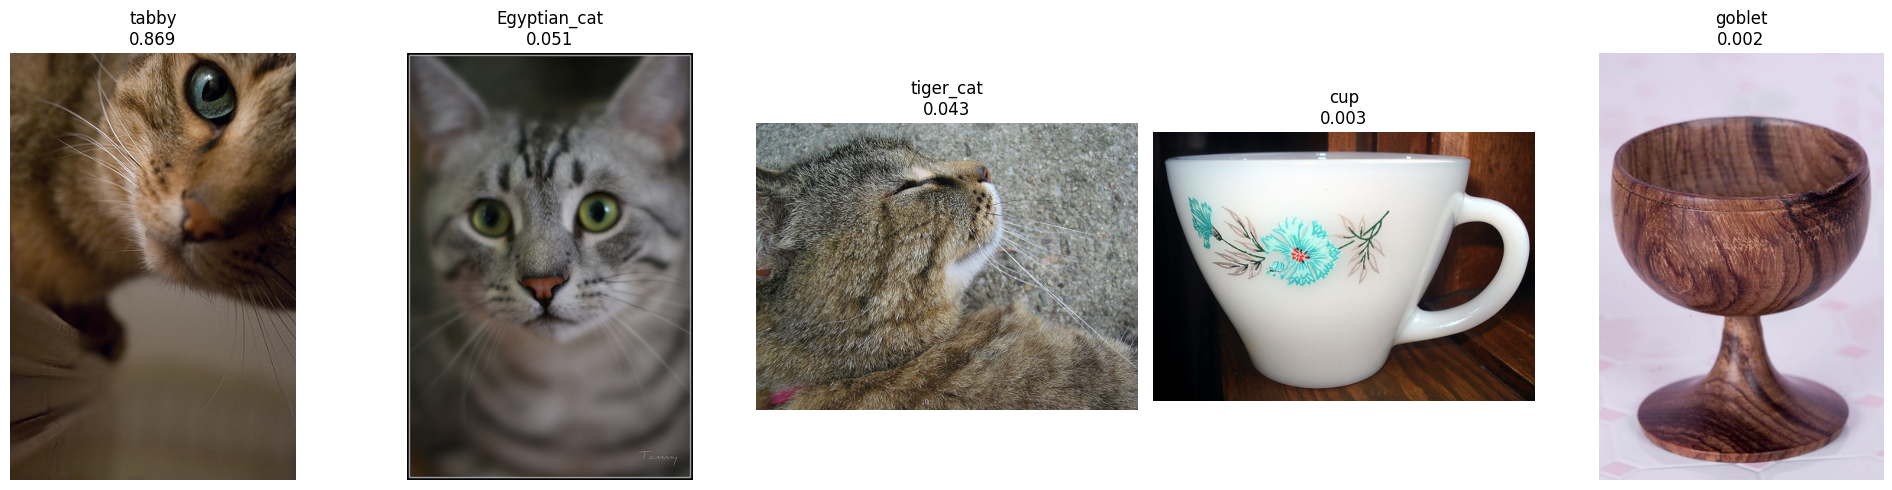

In [80]:
imagenet_cats = [("n02123045_tabby.JPEG", "tabby", "0.8686101"), 
  ("n02124075_Egyptian_cat.jpeg", "Egyptian_cat", "0.050775014"), 
  ("n02123159_tiger_cat.jpeg", "tiger_cat", "0.04256697"),
  ("n07930864_cup.jpeg", "cup", "0.0027631472"), 
  ("n03443371_goblet.jpeg", "goblet", "0.002099163")
]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(pred_cats), figsize=(20, 5))
for ax, (label, name, score) in zip(axes, pred_cats):
    cat_png = Image.open(data_path + '/imagenette/' + label + "_" + name + ".jpeg")
    ax.imshow(cat_png)
    ax.axis('off')
    ax.set_title(f"{name}\n{float(score):.3f}", fontsize=12)
plt.tight_layout()
plt.show()